In [1]:
#imports
from control import lqr
from scipy import integrate, signal
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def plot(t, v_i, a_i, d, d_ref, e, params: dict = 
         {"figsize": (12,7),
          "title": "Vehicle Dynamics"}):
    
    figsize = params['figsize']        
    title = params['title']

    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(t, d, label='Gap')
    ax1.plot(t, d_ref, label='Gap Reference')
    ax1.plot(t, e, label='Error')
    ax1.set_xlabel('Time (s)')
    ax1.set_title('Gap/Error Dynamics')
    ax1.legend()
    ax1.grid()

    ax2.plot(t, np.array(v_i)*3.6, 'b', label = 'Ego car speed')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity (km/h)')
    ax2.set_title('Input response')
    ax2.grid()
    ax2.legend()
    ax2.tick_params(axis='y', labelcolor='b')
    ax3 = ax2.twinx()
    ax3.plot(t, a_i, 'r', label = 'Actuation: Ego car acc')
    ax3.set_ylabel('Acceleration (m/s^2')
    ax3.tick_params(axis='y', labelcolor='r')
    ax3.legend()


# Constant Spacing Policy

## PID

[-1.00000000e+00 -8.41971276e-01 -7.00374873e-01 -5.73606801e-01
 -4.60198569e-01 -3.58808418e-01 -2.68203312e-01 -1.87310119e-01
 -1.15224309e-01 -5.10987795e-02  5.85884071e-03  5.63861880e-02
  1.01166166e-01  1.40818647e-01  1.75834696e-01  2.06633216e-01
  2.33610806e-01  2.57142180e-01  2.77580165e-01  2.95255702e-01
  3.10477845e-01  3.23526128e-01  3.34604412e-01  3.43883255e-01
  3.51526553e-01  3.57691510e-01  3.62528640e-01  3.66181766e-01
  3.68788020e-01  3.70477842e-01  3.71369274e-01  3.71530695e-01
  3.71024364e-01  3.69912758e-01  3.68256058e-01  3.66112151e-01
  3.63536631e-01  3.60582796e-01  3.57301653e-01  3.53741933e-01
  3.49949999e-01  3.45948712e-01  3.41752230e-01  3.37375499e-01
  3.32834250e-01  3.28145001e-01  3.23325056e-01  3.18392503e-01
  3.13366218e-01  3.08265864e-01  3.03111887e-01  2.97925521e-01
  2.92728786e-01  2.87539812e-01  2.82354714e-01  2.77170537e-01
  2.71985813e-01  2.66799906e-01  2.61613006e-01  2.56426135e-01
  2.51241142e-01  2.46060

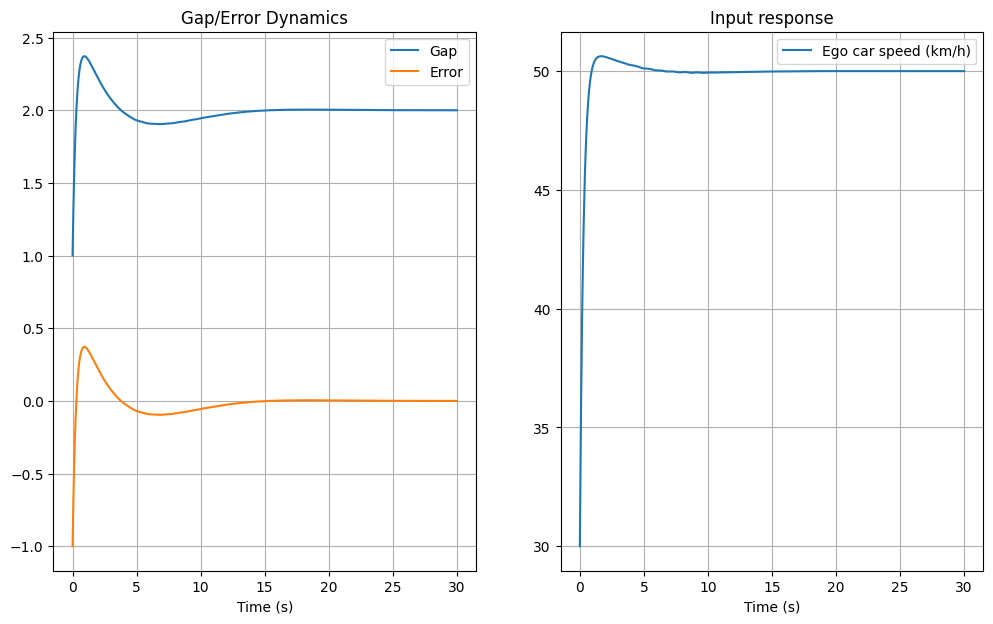

In [19]:
d_ref = 2 # gap target (m)

#PI constants
Kp = 2
Ki = 0.5
Kd = 4

def System(t: float, x: np.ndarray, v_fwd: float):
    y = x[0]
    e = y - d_ref #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = v_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = Kp*e + Ki*i_e + Kd*d_e 

    #dynamics:
    d_x1 = v_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

t_end = 30
t = np.linspace(0, t_end, 1000)
v_i_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 
u = 0 #car full stop
v_fwd = 50/3.6 # constant forward vehicle speed for now

x = integrate.solve_ivp(System, (0, t_end), x_0, t_eval=t, args=(v_fwd, )) #uses runge-kutta
d, v_i, I = x.y
y = d
e = y - d_ref
print(e)
plot(x.t, v_i, d, e)

## LQR

LQR Gain (K): [[-10.54281257   5.57544842  -1.        ]]
[-1.         -0.81810581 -0.61033145 -0.38243142 -0.1395057   0.11396258
  0.37414085  0.63778954  0.90205666  1.16447072  1.42293662  1.67578917
  1.92171438  2.15959747  2.38851726  2.60773771  2.81665646  3.01507536
  3.20292011  3.38015524  3.54678405  3.70284865  3.84842992  3.98364237
  4.10873935  4.22421577  4.33055765  4.4282177   4.51761523  4.59913626
  4.67313343  4.73992602  4.7998      4.85303942  4.90013428  4.9415821
  4.97783522  5.00930952  5.03638454  5.0594034   5.0786728   5.09446309
  5.10700819  5.11650565  5.12311659  5.12702343  5.1285938   5.12807386
  5.12567883  5.1216074   5.11604174  5.10914749  5.10107374  5.0919531
  5.08190159  5.07101876  5.05938759  5.04707456  5.0341296   5.02058612
  5.00657286  4.9922699   4.97770617  4.96290879  4.9479043   4.93271858
  4.91737692  4.90190399  4.88632382  4.87065986  4.85493491  4.83917117
  4.82339021  4.80761301  4.7918599   4.77615062  4.76050426  4.74493

/tmp/ipykernel_1057/133903492.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x) #convert array to single value


ValueError: x, y, and format string must not be None

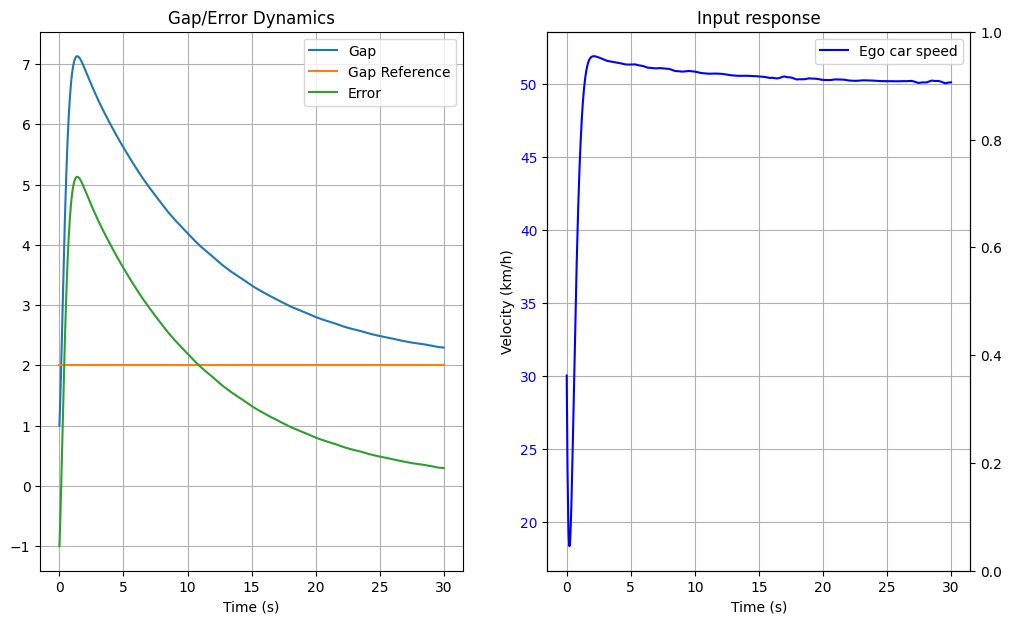

In [50]:
d_ref=2

# System dynamics (A, B matrices)
A = np.array([[0, -1, 0],
              [0,  0, 0],
              [1,  0, 0]])

B = np.array([[0], 
              [1], 
              [0]])

# Cost matrices
Q = np.diag([10, 1, 0.1])  # Penalize gap error, velocity error, and integral error
R = np.array([[0.1]])      # Penalize control effort

# Solve Riccati equation for LQR gain K
K, S, E = lqr(A, B, Q, R) # State feedback gains, Solution to Riccati equation, Eigenvalues of the closed loop system

print("LQR Gain (K):", K)

# Define system with LQR
def System(t: float, x: np.ndarray, v_fwd: float):
    y = x[0]
    e = y - d_ref #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = v_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = float(-K @ x) #convert array to single value

    #dynamics:
    d_x1 = v_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

t_end = 30
t = np.linspace(0, t_end, 1000)
v_i_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 
u = 0 #car full stop
v_fwd = 50/3.6 # constant forward vehicle speed for now

x = integrate.solve_ivp(System, (0, t_end), x_0, t_eval=t, args=(v_fwd, )) #uses runge-kutta
d, v_i, I = x.y
y = d
e = y - d_ref
d_ref_list = np.ones_like(x.t) * d_ref
print(e)
plot(x.t, v_i, None, d, d_ref_list, e)

# Constant Time Headway (CTH) Policy

## PID

[ 6.44444444e+00  6.27052030e+00  6.09943068e+00  5.93111939e+00
  5.76553178e+00  5.60261472e+00  5.44231654e+00  5.28458697e+00
  5.12937711e+00  4.97663940e+00  4.82632756e+00  4.67839653e+00
  4.53280248e+00  4.38950273e+00  4.24845573e+00  4.10962101e+00
  3.97295918e+00  3.83843187e+00  3.70600167e+00  3.57563218e+00
  3.44728788e+00  3.32093419e+00  3.19653739e+00  3.07406458e+00
  2.95348373e+00  2.83476355e+00  2.71787354e+00  2.60278397e+00
  2.48946578e+00  2.37789066e+00  2.26803093e+00  2.15985960e+00
  2.05335030e+00  1.94847728e+00  1.84521540e+00  1.74354006e+00
  1.64342727e+00  1.54485355e+00  1.44779597e+00  1.35223208e+00
  1.25813995e+00  1.16549813e+00  1.07428563e+00  9.84481914e-01
  8.96066879e-01  8.09020854e-01  7.23324576e-01  6.38959184e-01
  5.55906204e-01  4.74147542e-01  3.93665464e-01  3.14442595e-01
  2.36461902e-01  1.59706689e-01  8.41605797e-02  9.80751742e-03
 -6.33682511e-02 -1.35382182e-01 -2.06249441e-01 -2.75984917e-01
 -3.44603223e-01 -4.12118

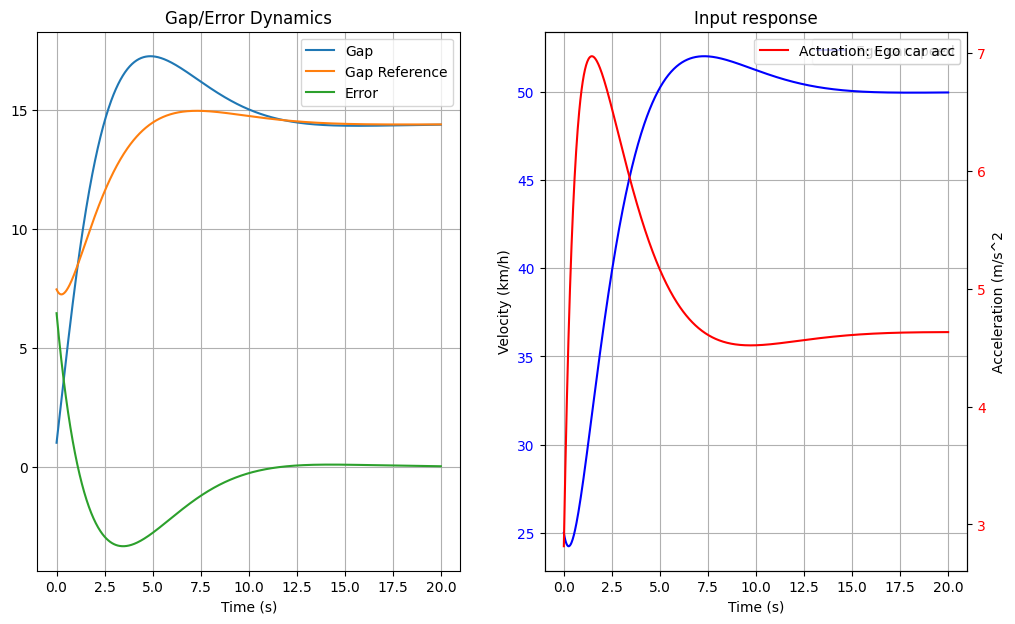

In [38]:
d_min = 0.5 #min gap (emergency)
v_p = 50/3.6 #constant leader speed for now
h = 1 #1s time headway

#PI constants
Kp = 3
Ki = 1
Kd = 4
denom = 1 - Kd * h

#simulation values
t_end = 20
t = np.linspace(0, t_end, 1000)
v_i_0 = 25/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 


#u1 = d_min
#u2 = v_i-1
u = np.zeros((t.shape[0], 2))
u[:, 0] = d_min # constant min gap
u[:, 1] = v_p 

#closed-loop state space system
A = np.array([
    [0, -1, 0],
    [-Kp/denom, (Kp*h + Kd)/denom, Ki/denom],
    [-1, h, 0]
])

B = np.array([
    [0 , 1],
    [Kp/denom, -Kp/denom],
    [1 , 0]
])

#y = gap = x1
C = np.array([1, 0, 0])
D = np.zeros((1, 2))

sys = signal.StateSpace(A, B, C, D)
t_out, y, x = signal.lsim(sys, u, t, x_0)
d_ref = d_min + h*x[:,1]
e = d_ref - x[:, 0]
act = (Kp*e + Ki*x[:,2] + Kd * (x[:,1] - v_p)) / (1 - Kd * h) #recover actuation computed by controller
print(e)
plot(t=t_out, v_i=x[:,1], a_i=act , d=x[:,0], d_ref=d_ref, e=e)


# Real-time

In [57]:
# RK45 scipy try, wasnt working
""" class vehicle:
    def __init__(self, Kp: float, Ki: float, Kd: float, x0: list, d_min: float=0.5, h: float=1):
        self.d_min = d_min
        self.h = h
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.v_p = 0 # preceeding vehicle speed to be updated

        self.x = np.array(x0, dtype=float)
        self.solver = integrate.RK45(self.compute, t0=0, y0=self.x, t_bound=0)
        # will have to update t_bound to evaluated t points for syncronization
        self.e_t = []
        self.u_t = []
        self.d_t = []
        self.v_t = []
        self.d_ref_t = []
        self.t = []
                
    def policy(self, v_i):
        d_ref = self.d_min + self.h*v_i
        return d_ref

    def pid(self, x, d_ref, v_p):
        d, v_i, i_e = x
        
        e = d_ref - d
        denom = 1 - self.Kd * self.h
        if np.abs(denom) < 1e-8: #dividing by 0 exception
            raise ValueError("Denom (1 - Kd*h) is zero. Adjust Kd and h.")
        
        u = (self.Kp * e + self.Ki * i_e + self.Kd * (v_i - v_p)) / denom
        
        return e, u

    def plant(self, x, e, u, v_p):
        d, v_i, i_e = x

        #dynamics:
        d_x1 = v_p - v_i #gap dynamics
        d_x2 = u #ego vehicle acceleration/velocity dynamics
        d_I = e #solver will integrate and we get integral(e) 
        
        return np.array([
            d_x1, #x1
            d_x2, #x2
            d_I # aux (error integral)
        ])

    def compute(self, t, x):
        v_p = self.v_p  # This should be updated in the step method
        v_i = x[1]
        d_ref = self.policy(v_i)
        e, u = self.pid(x, d_ref, v_p)
        new_x = self.plant(x, e, u, v_p)
        return new_x
    
    def step(self, v_p, t_bound):
        self.v_p = v_p
        self.solver.t_bound = t_bound #stop on required time instant (for syncing)
        if(self.solver.status == 'finished'):
            print("Stepped.")
            self.solver.status == 'running'
            self.solver.step()

        #save variables
        self.x = self.solver.y
        d, v = self.x[:2]
        t_curr = self.solver.t   
        self.t.append(t_curr)
        self.d_t.append(d)
        self.v_t.append(v)
        #retrace e, u and d_ref
        d_ref = self.policy(v)
        self.d_ref_t.append(d_ref)
        e, u = self.pid(self.x, d_ref, v_p) #TODO: and here 
        self.e_t.append(e)
        self.u_t.append(u)
         """

class Vehicle:
    def __init__(self, Kp: float, Ki: float, Kd: float, x0: list, 
                 d_min: float = 0.5, h: float = 1):
        # Controller parameters
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.d_min, self.h = d_min, h
        
        # State: [gap, velocity, integral_error]
        self.x = np.array(x0, dtype=float)
        
        self.history = {
            't': [], 'd': [], 'v': [], 
            'u': [], 'd_ref': [], 'e': []
        }

    def update(self, v_p, dt):
        """Update state for one time step using fixed-step integration"""
        
        d_ref = self.d_min + self.h * self.x[1] #policy
        e = d_ref - self.x[0] #error
        u = self._pid(e, self.x[1], v_p) #using PID for now
        
        # Store history
        self.history['d'].append(self.x[0])
        self.history['v'].append(self.x[1])
        self.history['u'].append(u)
        self.history['d_ref'].append(d_ref)
        self.history['e'].append(e)
        
        # Rk4
        k1 = self._dynamics(self.x, u, v_p)
        k2 = self._dynamics(self.x + 0.5*dt*k1, u, v_p)
        k3 = self._dynamics(self.x + 0.5*dt*k2, u, v_p)
        k4 = self._dynamics(self.x + dt*k3, u, v_p)
        
        self.x += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _pid(self, e, v_i, v_p):
        """Compute control input"""
        denom = 1 - self.Kd * self.h
        if abs(denom) < 1e-8:
            raise ValueError("Denominator near zero! Adjust Kd or h.")
        return (self.Kp*e + self.Ki*self.x[2] + self.Kd*(v_i - v_p)) / denom

    def _dynamics(self, x, u, v_p):
        '''Vehicle Dynamics in State-Space form'''
        d, v_i, i_e = x
        return np.array([
            v_p - v_i,  # Gap derivative
            u,          # Acceleration
            self.history['e'][-1] if self.history['e'] else 0  # Integral error
        ])

## Car-following (for comparison)

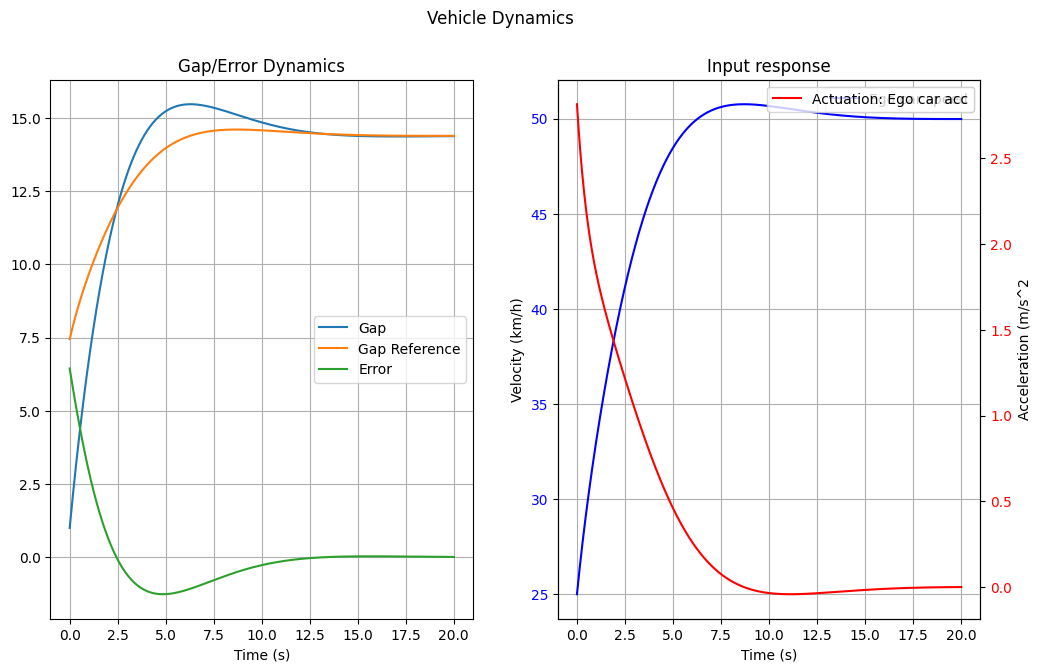

In [60]:
#----- globals
d_min=0.5
h=1
#PI constants
Kp = 3
Ki = 1
Kd = 4
#----

#simulation values
t_end = 20
dt = 0.01
t = np.arange(0, t_end+dt, dt)
lv_speed = np.ones_like(t) * 50/3.6 #constant leader speed
fv0_x0 = np.array([1, 25/3.6, 0])
fv0 = Vehicle(Kp=Kp, Ki=Ki, Kd=Kd, x0=fv0_x0, d_min=d_min, h=h) #initial state -> gap, km/h, error integral
for t_curr in t:
    fv0.update(v_p=lv_speed[0], dt=dt)

plot(t, fv0.history['v'], fv0.history['u'], fv0.history['d'], fv0.history['d_ref'], fv0.history['e'])

## Platooning

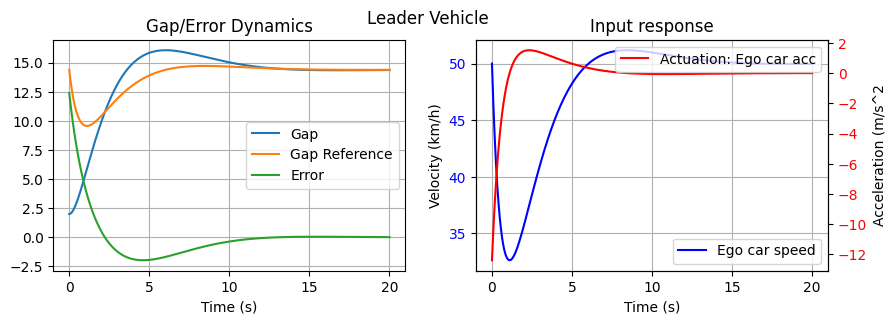

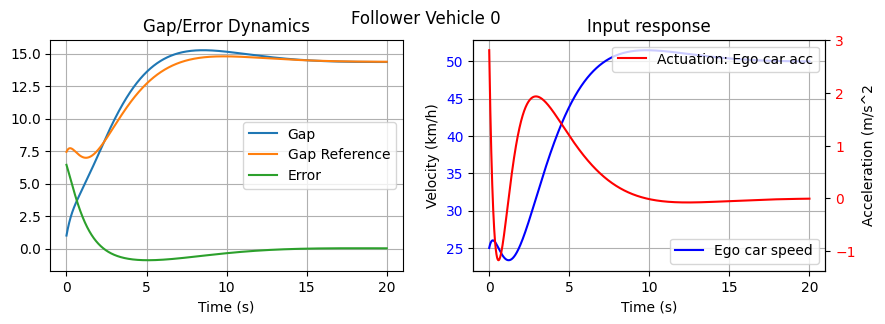

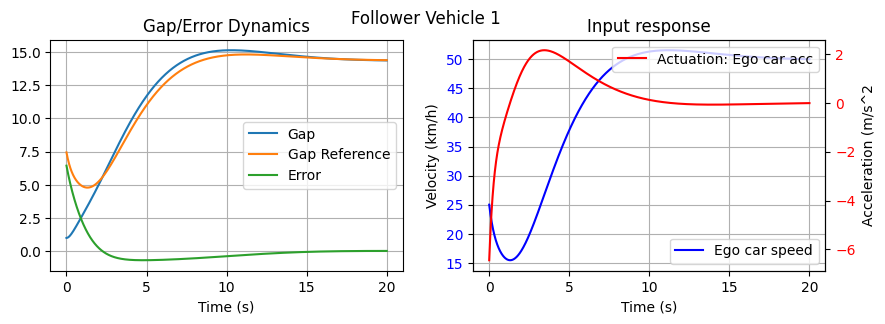

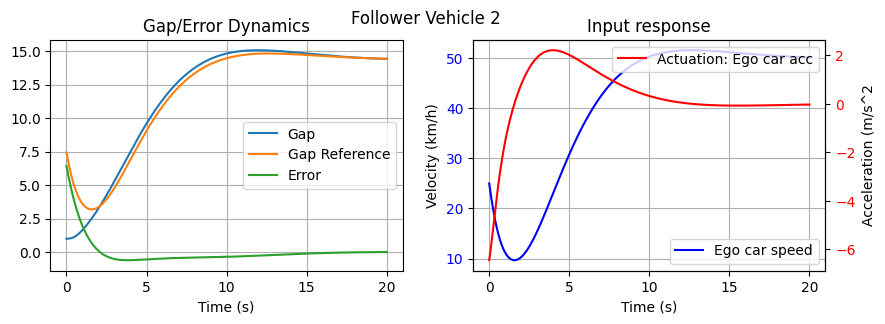

In [67]:
#----- globals
d_min=0.5
h=1
#PI constants
Kp = 3
Ki = 1
Kd = 4
#----

#simulation values
t_end = 20
dt = 0.01
t = np.arange(0, t_end+dt, dt)
lv_speed = np.ones_like(t) * 50/3.6 #constant leader speed
fv_x0 = np.array([1, 25/3.6, 0]) #same fv init for now
platoon_size = 4 #including leader

# Building platoon...
platoon = []
platoon.append(Vehicle(Kp=Kp, Ki=Ki, Kd=Kd, x0=[2, lv_speed[0], 0], d_min=d_min, h=h))
for i in range(1, platoon_size):
    platoon.append(Vehicle(Kp=Kp, Ki=Ki, Kd=Kd, x0=fv_x0, d_min=d_min, h=h)) #same vehicle parameters

# Simulate
for t_index, _ in enumerate(t):
    platoon[0].update(v_p=lv_speed[t_index], dt=dt) #can change leader speed later
    
    for i in range(1, platoon_size): #from front to back -> V2V PF topology (simpler)
        platoon[i].update(v_p=platoon[i-1].history['v'][-1], dt=dt) #preceeding vehicle communicates latest speed

#Plot
plot_params =  {
    "figsize": (10,3)
}
for i, vehicle in enumerate(platoon):
    if i==0:
        plot_params["title"] = "Leader Vehicle"
    if i>0:
        plot_params["title"] = "Follower Vehicle " + str(i-1) 
    plot(t, vehicle.history['v'], vehicle.history['u'], vehicle.history['d'], vehicle.history['d_ref'], vehicle.history['e'], plot_params)